In [1]:
import sklearn
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau

### The american sign language contains 26 letters, but the dataset contains only 24 different classes. This is due to the fact that the signs related to the J and Z letters require movement, so they can't be represented through static images.  

### El lenguaje de señas americano consta de 26 símbolos, pero la base de datos de la plataforma contiene 24, esto se debe a que los símbolos referentes a la J y a la Z requieren movimiento, por lo que no se pueden representar mediante imágenes estáticas.

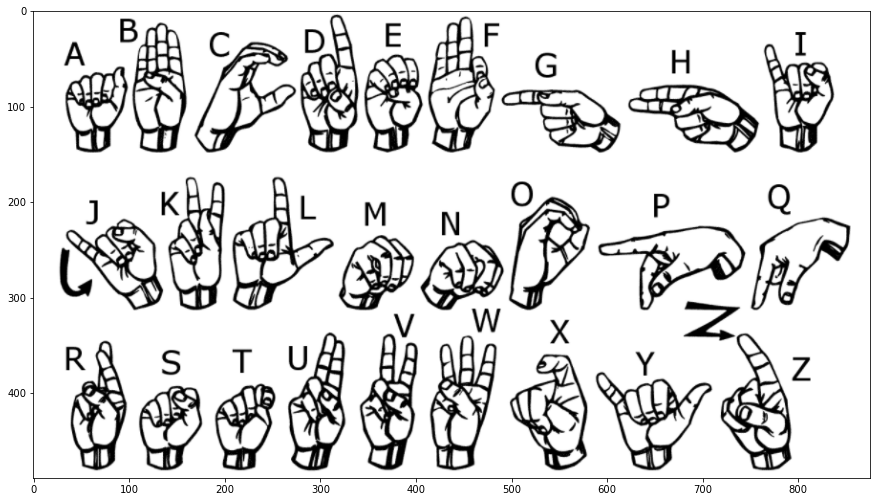

In [4]:
img = mpimg.imread("../Datos/american_sign_language.PNG")
plt.figure(figsize = (15, 12))
plt.imshow(img)

### The labels are the value of the position in which each letter is found in the alphabet (starting from 0). I will relate each letter to its index in order to reference the images.

### Las etiquetas son el valor de la posición en la que se encuentra cada letra en el abecedario (empezando desde 0). Voy a relacionar cada letra con su índice para poder referenciar las imágenes.

In [5]:
sig_labels = {}
letras = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
for i in range (26):
    sig_labels[i] = letras[i]

### The platform has separate training and test sets, so I will use that distribution and refrain from evaluating the model on the test set until it is complete.

### La plataforma tiene separados los conjuntos de entrenamiento y prueba, por lo que utilizaré esa distribución, sin evaluar el modelo en el conjunto de prueba hasta que esté completado.

In [6]:
train_val_set = pd.read_csv("../Datos/sign_mnist_train.csv")

train_val_y_df = train_val_set["label"]
train_val_X_df = train_val_set.drop("label", axis = "columns")

train_val_y = train_val_y_df.to_numpy()
train_val_X = train_val_X_df.to_numpy()

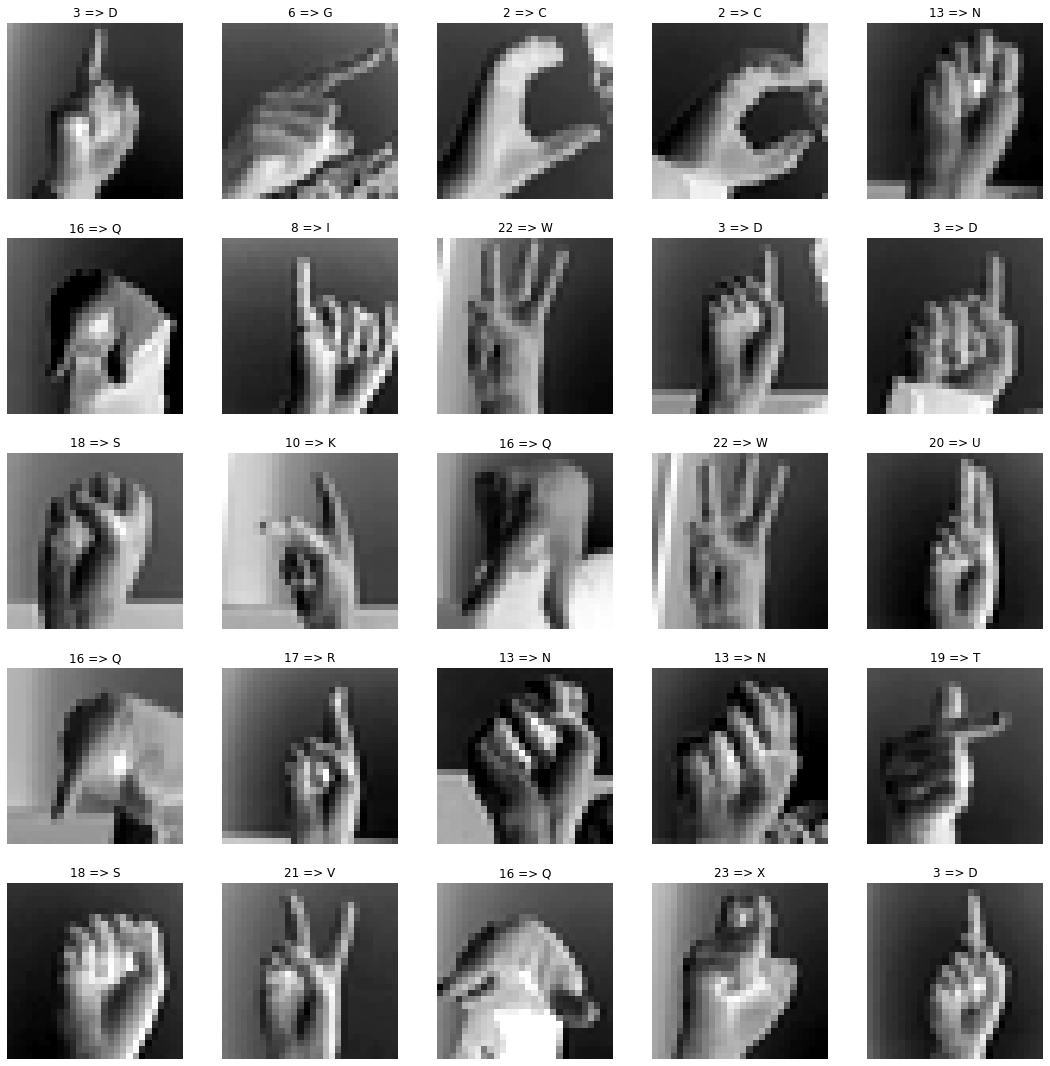

In [7]:
examples25 = train_val_X[0 : 25]

figs, axs = plt.subplots(5, 5, figsize = (15, 15))
contr = 0 # row
contc = 0 # column
figs.tight_layout(pad = 0.5)
for i in range(25):
    axs[contr, contc].imshow(examples25[i].reshape(28, 28), cmap = mpl.cm.binary)
    axs[contr, contc].set_title("%s => %s" %(train_val_y[i], sig_labels[train_val_y[i]]))
    axs[contr, contc].axis("off")
    contc += 1
    if contc == 5:
        contr += 1
        contc = 0

#### It is important for the images to be shuffled (not arranged in alphabetical order, such as all A first, then B, etc.) as some models are sensitive to the order of elements and can produce poor results if they are not properly shuffled. Analyzing the first 25 samples, we can see that they are already shuffled.

#### Es importante que las imagenes esten mezcladas (que no sean primero todas A, luego B, ...) ya que algunos modelos son sensibles al orden de los elementos, y obtienen malos resultados si no estan bien mezclados. Analizando las primeras 25 muestras vemos que ya están mezcladas.

#### I am going to triple the size of the training and validation sets using artificial data extension.

#### Voy a utilizar la extensión artificial para triplicar el tamaño del conjunto de entrenamiento y validación.

In [8]:
train_val_X_for_extension = train_val_X.reshape(27455, 28, 28, 1).copy()

In [9]:
datagen1 = ImageDataGenerator(width_shift_range = 0.15, height_shift_range = 0.1)
X_new_1_raw = datagen1.flow(train_val_X_for_extension, shuffle = False, batch_size = 27455)

datagen2 = ImageDataGenerator(rotation_range = 20)
X_new_2_raw = datagen2.flow(train_val_X_for_extension, shuffle = False, batch_size = 27455)

In [10]:
X_new_1 = X_new_1_raw[0].copy()
X_new_2 = X_new_2_raw[0].copy()

In [11]:
X_train_val_extended = np.concatenate((train_val_X_for_extension, X_new_1, X_new_2), axis = 0)
y_train_val_extended = np.concatenate((train_val_y, train_val_y, train_val_y))

In [12]:
X_train_val_extended.shape, y_train_val_extended.shape

((82365, 28, 28, 1), (82365,))

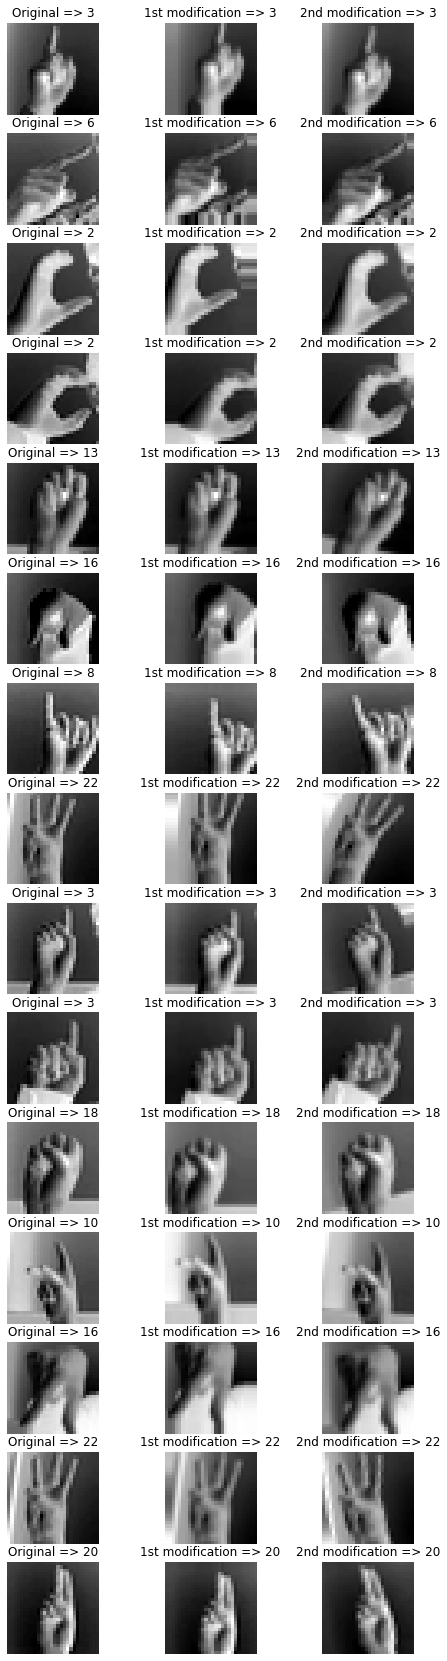

In [13]:
figs, axs = plt.subplots(15, 3, figsize = (8, 30))
contf = 0
contc = 0

for i in range(15):  
    
    axs[i, 0].imshow(X_train_val_extended[i], cmap = mpl.cm.binary)
    axs[i, 0].axis("off")
    
    axs[i, 1].imshow(X_train_val_extended[27455 + i], cmap = mpl.cm.binary)
    axs[i, 1].axis("off")
    
    axs[i, 2].imshow(X_train_val_extended[27455 * 2 + i], cmap = mpl.cm.binary)
    axs[i, 2].axis("off")
    
    axs[i, 0].set_title("Original => %s" %(y_train_val_extended[i]))
    axs[i, 1].set_title("1st modification => %s" %(y_train_val_extended[27455 + i]))  
    axs[i, 2].set_title("2nd modification => %s" %(y_train_val_extended[27455 * 2 + i])) 
    

##### Now, I will shuffle the complete dataset and divide it into the training set and the validation set. Although the random forest does not use the validation set for training, comparing the accuracies obtained on the test and validation sets will allow me to assess if the model can generalize well to both similar samples used in training and relatively different samples.

##### Ahora voy a mezclar el conjunto completo y dividirlo en el conjunto de entrenamiento y el conjunto de validación. Aunque el bosque aleatorio no utiliza el conjunto de validación para el entrenamiento, al comparar la precisión la precisiones obtenidas en los conjuntos de prueba y validación podré valorar si el modelo es capaz de generalizar correctamente tanto a muestras parecidas a las utilizadas en el entrenamiento como a muestras relativamente diferentes.

In [14]:
X_train_val_sf , y_train_val_sf = shuffle(X_train_val_extended, y_train_val_extended)

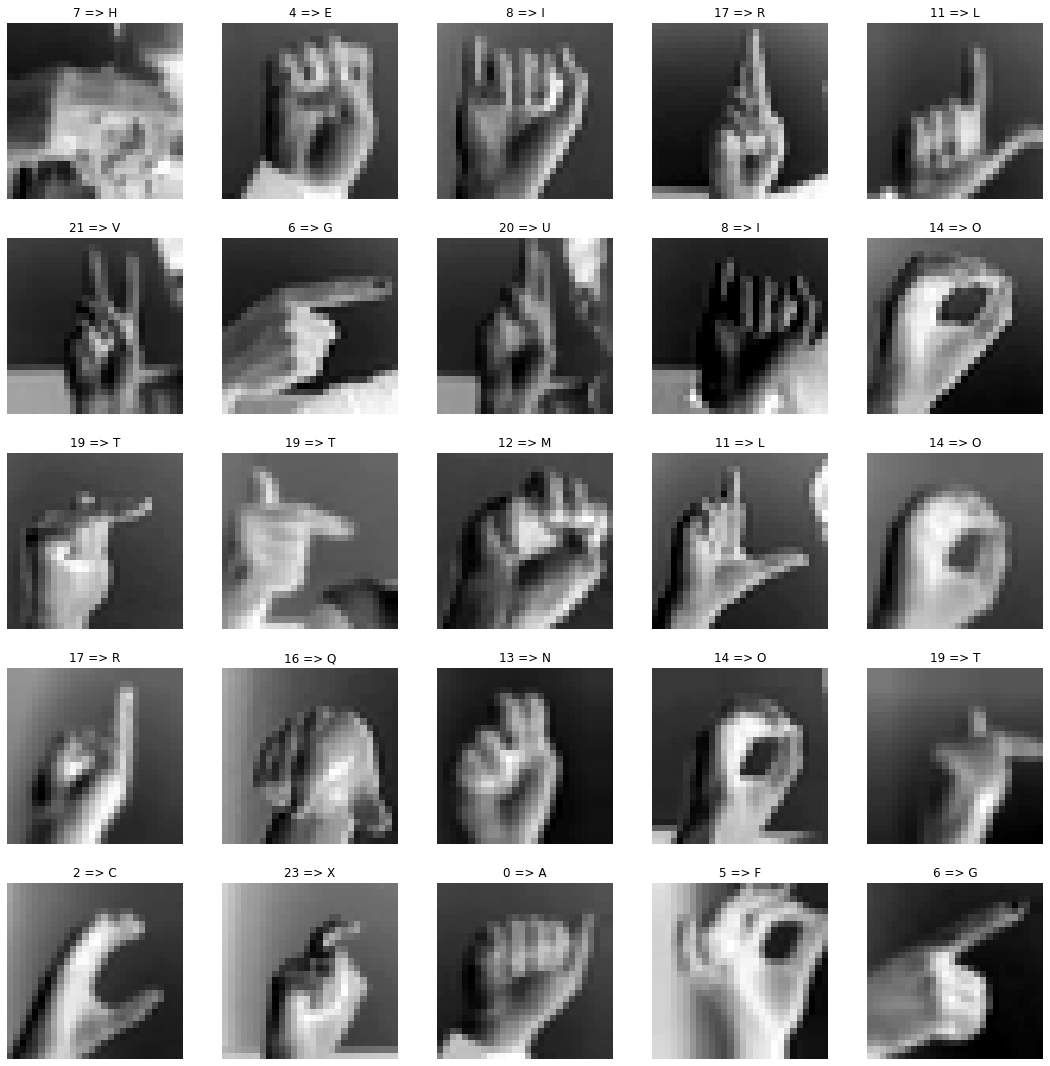

In [15]:
figs, axs = plt.subplots(5, 5, figsize = (15, 15))
contr = 0
contc = 0
figs.tight_layout(pad = 0.5)
for i in range(25):
    axs[contr, contc].imshow(X_train_val_sf[i], cmap = mpl.cm.binary)
    axs[contr, contc].set_title("%s => %s" %(y_train_val_sf[i], sig_labels[y_train_val_sf[i]]))
    axs[contr, contc].axis("off")
    contc += 1
    if contc == 5:
        contr += 1
        contc = 0

##### I will rescale the pixel values from the range [0, 255] to [0, 1].

##### Voy a reducir el rango de los valores de los píxeles desde [0, 255] hasta [0, 1].

In [16]:
X_train = X_train_val_sf[0 : 75000].copy().reshape(75000, 784) / 255.0
y_train = y_train_val_sf[0 : 75000].copy()

X_val = X_train_val_sf[75000 : ].copy().reshape(82365 - 75000, 784) / 255.0
y_val = y_train_val_sf[75000 :].copy()

## Now I will create and train the network

## Ahora voy a crear y a entrenar la red

In [17]:
DNN = Sequential([
    
    Dense(units = 400, kernel_initializer = "lecun_normal",
          use_bias = False, input_shape = [784]),
    # use bias can be set to false since we will later add a batch normalization layer
    # use bias puede ser falso ya que luego vamos a añadir capasa de BN
    
    BatchNormalization(),
    
    Activation("selu"),
    
    
    
    Dense(units = 400, kernel_initializer = "lecun_normal",
        use_bias = False), 
    # use bias can be set to false since we will later add a batch normalization layer
    # use bias puede ser falso ya que luego vamos a añadir capasa de BN
    
    BatchNormalization(),
    
    Activation("selu"),
    
    
    
    Dense(units = 400, kernel_initializer = "lecun_normal",
         use_bias = False), 
    # use bias can be set to false since we will later add a batch normalization layer
    # use bias puede ser falso ya que luego vamos a añadir capasa de BN
    
    BatchNormalization(),
    
    Activation("selu"),
    
    
    
    Dense(units = 400, kernel_initializer = "lecun_normal",
          use_bias = False), 
    # use bias can be set to false since we will later add a batch normalization layer
    # use bias puede ser falso ya que luego vamos a añadir capasa de BN
    
    BatchNormalization(),
    
    Activation("selu"),
    
    
    
    Dense(units = 400, kernel_initializer = "lecun_normal",
          use_bias = False), 
    # use bias can be set to false since we will later add a batch normalization layer
    # use bias puede ser falso ya que luego vamos a añadir capasa de BN
    
    BatchNormalization(),
    
    Activation("selu"),
    
    
    
    Dense(units = 25, activation = "softmax",
          kernel_initializer = "glorot_uniform")
   
    
])

In [18]:
DNN.compile(optimizer = "nadam",
             loss = "sparse_categorical_crossentropy",
             metrics = ["accuracy"])

In [19]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("Modelos/DNN.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 8, restore_best_weights = True)
lr_scheduler = ReduceLROnPlateau(factor = 0.5, patience = 5,
                                 verbose = 1, monitor = "val_accuracy")

In [20]:
DNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               313600    
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
activation (Activation)      (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)               1600      
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               1

In [21]:
history_DNN = DNN.fit(X_train, y_train, epochs = 100,
                        validation_data = (X_val, y_val),
                        callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler])

Epoch 1/100
2344/2344 [==============================] - 136s 58ms/step - loss: 0.9023 - accuracy: 0.7233 - val_loss: 1.2951 - val_accuracy: 0.6295
Epoch 2/100
2344/2344 [==============================] - 136s 58ms/step - loss: 0.4165 - accuracy: 0.8679 - val_loss: 1.9742 - val_accuracy: 0.5117
Epoch 3/100
2344/2344 [==============================] - 137s 58ms/step - loss: 0.2932 - accuracy: 0.9057 - val_loss: 1.4559 - val_accuracy: 0.6365
Epoch 4/100
2344/2344 [==============================] - 134s 57ms/step - loss: 0.2268 - accuracy: 0.9269 - val_loss: 0.7716 - val_accuracy: 0.7760
Epoch 5/100
2344/2344 [==============================] - 135s 58ms/step - loss: 0.1901 - accuracy: 0.9388 - val_loss: 2.7062 - val_accuracy: 0.5301
Epoch 6/100
2344/2344 [==============================] - 137s 59ms/step - loss: 0.1593 - accuracy: 0.9470 - val_loss: 1.2810 - val_accuracy: 0.7359
Epoch 7/100
2344/2344 [==============================] - 136s 58ms/step - loss: 0.1391 - accuracy: 0.9541 - val_

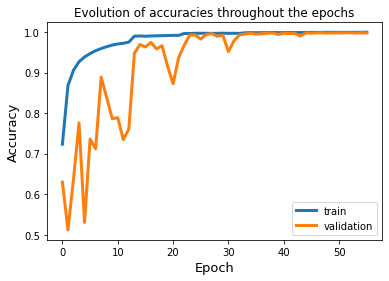

<Figure size 1080x648 with 0 Axes>

In [22]:
plt.plot(history_DNN.history['accuracy'], linewidth = 3)
plt.plot(history_DNN.history['val_accuracy'], linewidth = 3)
#plt.plot(history_DNN.history['loss'], linewidth = 1)
#plt.plot(history_DNN.history['val_loss'], linewidth = 1)
plt.title('Evolution of accuracies throughout the epochs')
plt.ylabel('Accuracy', fontsize = 13)
plt.xlabel('Epoch', fontsize = 13)
plt.legend(['train', 'validation'], loc='lower right')
plt.figure(figsize=(15,9))
plt.show()

### Now I am going to evaluate the network using the training and validation sets.

### Ahora voy a evaluar la red mediante los conjuntos de entrenamiento y validación:

In [23]:
DNN.evaluate(X_train, y_train), DNN.evaluate(X_val, y_val)

231/231 [==============================] - 5s 22ms/step - loss: 0.0062 - accuracy: 0.9982


([2.8550735805765726e-05, 1.0], [0.006190493702888489, 0.9982348680496216])

### The results obtained in both sets have been incredibly good, achieving 100% accuracy on the training set and 99.82% accuracy on the validation set. 
### Now I will evaluate the model on the test set:

### Los resultados obtenidos en ambos conjuntos han sido increblemente buenos, obteniendo una precisión del 100% en el conjunto de entrenamiento y una precisión del 99.82% en el conjunto de validación.
### Ahora evaluaré el modelo en el conjunto de prueba:

In [25]:
test_set = pd.read_csv("../Datos/sign_mnist_test.csv")

test_y_df = test_set["label"]
test_X_df = test_set.drop("label", axis = "columns")

test_y = test_y_df.to_numpy()
test_X = test_X_df.to_numpy()

In [26]:
test_X.shape, test_y.shape

((7172, 784), (7172,))

In [27]:
X_test = test_X.copy() / 255.0
y_test = test_y.copy()

In [28]:
DNN.evaluate(X_test, y_test)

225/225 [==============================] - 5s 22ms/step - loss: 0.0800 - accuracy: 0.9925


[0.08002476394176483, 0.9924707412719727]

## The accuracy of the network on the test set is 99.25%!!
## The network correctly predicted 7118 samples out of the 7172 samples in the test set.

## ¡¡La precisión de la red en el conjunto de prueba es del 99.25%!!
## La red ha predicho correctamente 7118 muestras de las 7172 que contiene el conjunto de prueba.

## I will draw the confusion matrix to analyze the errors made by the network.

## Voy a dibujar la matriz de confusión analizando los errores cometidos por la red.

In [29]:
pred_DNN = np.argmax(DNN.predict(X_test), axis = 1)

In [30]:
conf_mx = confusion_matrix(y_test, pred_DNN)

In [31]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


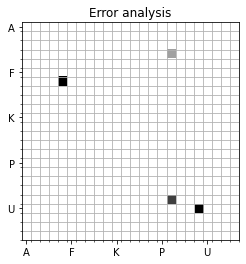

<Figure size 1440x1440 with 0 Axes>

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
minor_tick = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5,
              11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5,
              20.5, 21.5, 22.5, 23.5, 24.5]
ax.set_xticks(minor_tick, minor=True)
ax.set_yticks(minor_tick, minor=True)
ax.imshow(norm_conf_mx, cmap = plt.cm.gray.reversed())

labels = list("AAFLQV")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.grid(which='minor', alpha=1)

plt.title("Error analysis")
plt.figure(figsize = (20, 20))
plt.show()

### I will save the created model:

### Voy a guardar el modelo creado:

In [33]:
DNN.save("Modelos/DNN_definitive.h5")

## CONCLUSIÓN:

### La red obtenida ha conseguido unas precisiones del 100% y 99.82% en los conjuntos de entrenamiento y validación, respectivamente, los cuales han sido utilizados para la puesta a punto del modelo. La prueba definitiva de validez se ha realizado mediante el conjunto de prueba, logrando una precisión del 99.25%. De esta forma, la red neuronal convencional profunda creada puede considerarse más que eficaz para afrontar la tarea abordada.

## Conclusion:

### The obtained network has achieved accuracies of 100% and 99.82% on the training and validation sets, respectively, which were used for training and fine-tuning the model. The ultimate test of validity was conducted on the test set, resulting in an accuracy of 99.25%. Thus, the created deep conventional neural network can be considered highly effective in tackling the addressed task.